In [3]:
import numpy as np 
import pandas as pd 
import numba 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy import interpolate
from scipy.stats import linregress
from itertools import product
import time
from tqdm import tqdm
import altair as alt
from IPython.display import Image

# Introduction
Almost every tutorial on how to optimize a program starts with the quote: 
> *Premature optimization is the root of all evil*.  

As [this post](https://softwareengineering.stackexchange.com/a/80092) explains this means: 
> What this means is that, in the absence of measured performance issues you shouldn't optimize because you think you will get a performance gain. There are obvious optimizations, but anything that isn't a trivially clear optimization should be avoided until it can be measured.
The biggest problems with "premature optimization" are that it can introduce unexpected bugs and can be a huge time waster.

Before writing any code, therefore, it is a good idea to benchmark the existing code in order to find out which operations need to be sped up and which are already good enough (because for example they only take 1% of the total execution time).

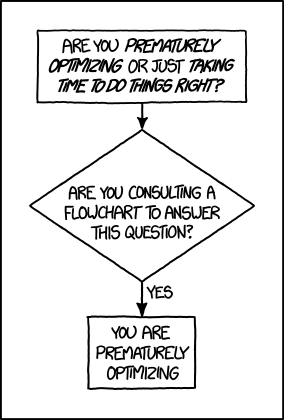

In [4]:
#The above quote is relevant to any project because apparently even seasoned programmers are tricked into prematurely optimizing:
Image("https://imgs.xkcd.com/comics/optimization.png")

# Profiling
Python and Jupyter offer many tools to benchmark code (e.g. by counting function calls, etc.). Since most of them are too advanced we adopt the simplest one: we use the `%%time` cell magic to time the execution of critical notebook cells. This has the disadvantage of yielding a result dependent on statistical fluctuations (`%%timeit` would be more robust but also time consuming) and on the machine used, but still provides useful and easy to read insight on our code - as long as we only consider "relative" informations.   
The result of such timing on a Google Colab machine yielded the following results:

In [10]:
#measured time = milliseconds
df_profiling = pd.read_csv("dati_per_visualizzare_il_profiling.csv",sep=";")
#CPU to wall time ratio
df_profiling["CWR"] = df_profiling["CPU_TIME"]/df_profiling["WALL_TIME"]
#number of cell
df_profiling["N_OF_CELL"] = df_profiling.index.values + 1
#total execution time in 'x m y s' format (minutes, seconds)
df_profiling["EXEC_TIME"]  = np.floor((df_profiling["WALL_TIME"]*1e-3)/60).astype("int").astype("str") + "m" + " " #minutes
df_profiling["EXEC_TIME"] += np.round(((df_profiling["WALL_TIME"]*1e-3)/60 - np.floor((df_profiling["WALL_TIME"]*1e-3)/60))*60, decimals=3).astype("str") + "s" #seconds

alt.Chart(df_profiling).mark_point(filled=True).encode(
    alt.X("N_OF_CELL"),
    alt.Y("WALL_TIME"),
    alt.Color("CWR"),
    alt.OpacityValue(0.7),
    tooltip = [alt.Tooltip("CELL"),alt.Tooltip("N_OF_CELL"),alt.Tooltip("CWR"),alt.Tooltip("EXEC_TIME")]
).configure_point(size=150)#.interactive()

alt.Chart(...)

The above graph tells us two important results:
- Every cell has a CPU to wall time ratio of $\approx 1$. Since the wall time is the total time it took to execute the cell (as if we had been staring at a clock on a wall) whereas CPU time is the time the CPU was actually busy this means that the main bottleneck of our code is the set of inefficient operations our CPU has to process. This is reasonable; the above graph was built using only `data_000000.txt` (i.e. few data points, less than 80 mb), so the machine didn't have to (for example) move a lot of data around in the RAM or to wait for the txt to download from the internet. This also helps us explain why the very first cell (`data_acquisition`) has a CWR of 0.23: the Colab VM had to download the csv from dropbox, which is slower than fitting it into RAM or processing with `pd.read_csv()`.
*Key idea*: we need to find alternative/more optimized version of our algorithms in order to reduce/make more efficient the computations we performed.
- Even though the actual numerical information on the Y axis doesn't have much meaning due to statistical/hw fluctuations we can clearly see that identifying events is the slowest part of our program, and this tells us that it's probably a good idea to heavily modify that cell. We can also see that applying the "close" filter is somewhat slow, too - so it's sensible to optimize that cell but not necessarily reworking it from the groud up. Similar things can be said about e.g. the computation of XL/XR and some other cells, although as said in the beginning except for obvious improvements for most cells here spending time optimizing would simply not make sense.
*Key idea*: we want to completely rewrite the algorithms used to group non-spurious hits and slightly overhaul the other cells. The point where to stop is of course arbitrary as optimization can be a never ending process; therefore we can stop when we feel satisfied with the result.

# Part 0: data acquisition and preprocessing

In [ ]:
start = time.time()

In [11]:
#DATA ACQUISITION (exactly as in the original code)
dataset = pd.read_csv("data_000000.txt")

ntriggers = dataset[(dataset['TDC_CHANNEL'] == 137) | (dataset['TDC_CHANNEL'] == 138)].shape[0]
triggers = dataset[dataset['TDC_CHANNEL'] == 139].shape[0]
total_orbits = dataset['ORBIT_CNT'].nunique()

dataset['TIME'] = dataset['BX_COUNTER']*25 + dataset['TDC_MEAS']*25/30

fpga = dataset['FPGA'] == 1 
channel = (dataset['TDC_CHANNEL'] > 64) & (dataset['TDC_CHANNEL'] <= 128) 
trigger = dataset['TDC_CHANNEL'] == 139 

detectors = [~fpga & ~channel, ~fpga & channel, fpga & ~channel, fpga & channel] 
for i in range(len(detectors)) : 
    dataset.loc[detectors[i],'DETECTOR'] = i+1 
dataset.loc[trigger,'DETECTOR'] = 0 

rest = dataset['TDC_CHANNEL'] % 4 
dic_replace = {0:1, 2:2, 3:3, 1:4}
dataset['LAYER'] = rest
dataset['LAYER'].replace(dic_replace, inplace=True)
dataset.loc[trigger,'LAYER'] = 0 
dataset = dataset.drop(['HEAD','FPGA'],axis=1) 

dataset

,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER
0,116,1897414884,1533.0,24.0,38345.000000,4.0,1
1,71,1897414887,1650.0,21.0,41267.500000,4.0,3
2,67,1897414914,980.0,8.0,24506.666667,4.0,3
3,70,1897414922,1287.0,8.0,32181.666667,4.0,2
4,57,1897414922,2162.0,22.0,54068.333333,1.0,4
...,...,...,...,...,...,...,...
1292121,139,1920940255,2514.0,0.0,62850.000000,0.0,0
1292122,35,1920940255,2512.0,16.0,62813.333333,3.0,3
1292123,37,1920940255,2513.0,5.0,62829.166667,3.0,4
1292124,105,1920940255,2510.0,17.0,62764.166667,4.0,4


## About data types
If we wanted to fully analyze our dataset (50+ gb) it obviously wouldn't fit in most computers' memory; even if we only took, say, 20%, we'd have 10+ gb of data - definitely manageable but still a lot. In order to avoid slow-downs due to memory saturation in any case using more efficient data types can reduce by a significant amount memory footprint. For example: every number in the original csv is an integer (no need to use floats) bigger than 0 (no need to use signed integers) and which can fit inside 8 or 32 bit. We can quickly compute which data type to use for each column of our dataset and measure the memory gain as follows:

In [15]:
dataset_slim = dataset.dropna() #no int nan exists, so the following line fails without dropna
dataset_slim = dataset_slim.astype({"TDC_CHANNEL":np.uint8,"ORBIT_CNT":np.uint32,"BX_COUNTER":np.uint16,"TDC_MEAS":np.uint8,"DETECTOR":np.uint8,"LAYER":np.uint8,"TIME":np.uint32})
print("dataset memory usage:")
dataset.info(memory_usage="deep")
print("\n"+"dataset_slim memory usage:")
dataset_slim.info(memory_usage="deep")

dataset memory usage:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1292126 entries, 0 to 1292125
Data columns (total 7 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   TDC_CHANNEL  1292126 non-null  int64  
 1   ORBIT_CNT    1292126 non-null  int64  
 2   BX_COUNTER   1292125 non-null  float64
 3   TDC_MEAS     1292125 non-null  float64
 4   TIME         1292125 non-null  float64
 5   DETECTOR     1292126 non-null  float64
 6   LAYER        1292126 non-null  int64  
dtypes: float64(4), int64(3)
memory usage: 69.0 MB

dataset_slim memory usage:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1292125 entries, 0 to 1292124
Data columns (total 7 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   TDC_CHANNEL  1292125 non-null  uint8 
 1   ORBIT_CNT    1292125 non-null  uint32
 2   BX_COUNTER   1292125 non-null  uint16
 3   TDC_MEAS     1292125 non-null  uint8 
 4   TIME         129

As we can see the default pandas type inference means we use data types much bigger than what we actually need (given the fact that for example DETECTOR is equal to 1,2,3 or 4); as a result the memory needed to fit our dataset drops from 69.0 to 27.1 mb. In what follows, though, we won't actually implement this type assignments for the following reasons:
- as we have seen from the interactive plot every nontrivial cell has $CWR\approx 1$, i.e. memory isn't an issue *with the size of this particular dataset*.
- actually using the above strategy would require nontrivial modifications of every cell. For example we observe that no integer NaN exists in python, therefore everytime we use a NaN to flag and remove spurious hits that assignment would fail. We could use another flag value; for example we may switch to using a negative number like -1 (but that would require signed integers) or the max value (but that would rule out a simple way to drop hits). Due to the fact that we don't need to implement this modifications and that we aren't trying to write the most general code possible we simply do nothing with regard to data types (according to the general guidelines given in the introduction).

## Using ORBIT_CNT as index
One of the purposes of this project is to identify with a common EVENT label hits belonging to the same event; therefore it's conceptually useful to use ORBIT_CNT (and later EVENT) to index hits. It also makes the code easier to understand; this is the first true new feature of this part of the project (along with the fact that we more aggressively drop useless columns to save memory).

In [16]:
df = dataset #.copy() #useful for debugging without reloading the dataset
# df[df.TDC_CHANNEL == 139] yields all the rows with tdc_channel = 139, therefore by extracting their indices we can find out which indices i.e. orbits contain at least one trigger activation.

df = df.set_index("ORBIT_CNT")
df = df.loc[df[df.TDC_CHANNEL == 139].index] #this removes indices i.e. orbits without any trigger activation
df = df.drop(["BX_COUNTER","TDC_MEAS"],axis=1) #no longer needed
df

,TDC_CHANNEL,TIME,DETECTOR,LAYER
ORBIT_CNT,,,,
1897414934,24,50360.833333,1.0,1
1897414934,26,50366.666667,1.0,2
1897414934,26,50660.833333,1.0,2
1897414934,139,50700.000000,0.0,0
1897414934,33,50661.666667,1.0,4
...,...,...,...,...
1920940255,101,62761.666667,4.0,4
1920940255,139,62850.000000,0.0,0
1920940255,35,62813.333333,3.0,3


## Efficiently removing orbits with too few hits
In order to efficiently remove orbits with less than 2 hits we can use `df.groupby(["ORBIT_CNT"],group_keys=False).size() > 2` to (fancy) index our dataframe; this is true because this line yields a (smaller) dataframe where every row is indexed by a unique value of ORBIT_CNT and tells us how many hits have that value of the index i.e. orbit.

In [17]:
#%%time
df = df[df.groupby(["ORBIT_CNT"],group_keys=False).size() > 2]
df

,TDC_CHANNEL,TIME,DETECTOR,LAYER
ORBIT_CNT,,,,
1897414934,24,50360.833333,1.0,1
1897414934,26,50366.666667,1.0,2
1897414934,26,50660.833333,1.0,2
1897414934,139,50700.000000,0.0,0
1897414934,33,50661.666667,1.0,4
...,...,...,...,...
1920940255,101,62761.666667,4.0,4
1920940255,139,62850.000000,0.0,0
1920940255,35,62813.333333,3.0,3


Since we'll actually need to use the previous filter again later we write a function to perform this cut. One way to do this is to simply use `.groupby("ORBIT_CNT").size()` as above; another is to use a pure numpy implementation (which we only report here for completeness' sake, since it doesn't seem to lead to substantial/consistent speed improvements).

In [18]:
#By applying np.unique to df.index we get an array containing unique values of ORBIT_CNT; np.unique can also be asked to return an array with the number of occurrences of each ORBIT_CNT value (i.e. the number of hits per each orbit) and the array that needs to be used with fancy indexing on the unique values array in order to rebuild the original array. By fancy indexing counts instead of unq with unqtags we can rebuild the original array but with the number of occurrences of each orbit in each slot - the number of hits happening in orbit x, that is. The result is identical to using groupby as already done

def remove_indexes_with_less_than_2_items(x) :
    unq,unqtags,counts = np.unique(x.index,return_inverse=True,return_counts=True)
    return x[counts[unqtags] > 2]

def remove_indexes_with_less_than_2_items_groupby(x) : 
    return x[x.groupby(x.index,group_keys=False).size() > 2]

## Efficient events identification and time pedestals computation
The following algorithm unifies 2-3 cells in the original program while also using a small fraction of the time needed; in fact we want to identify physical events, assign them the appropriate time pedestal, and finally drop events that last too long to be physical. 

# SPIEGA BROADCASTING

In [19]:
#First we compute all possible time pedestal values by recalling that each hits has a time pedestal equal to the time of closest trigger activation
v = df.loc[df["TDC_CHANNEL"] == 139,"TIME"].groupby("ORBIT_CNT").apply(np.array) #no need to use .to_numpy() since we actually want a series (we need the indices)
print(v)

#Notice: due to .apply(np.array) each slot of v is an array with 1 or more elements; for example v[22] contains 2 trigger activations, i.e. 4 items pairwise equal (we'll need to use np.unique to deal with this).
#this cell might be made slow by .apply(), but it's fast enough that we don't need to worry - and any alternative implementation would probably be less readable.

ORBIT_CNT
1897414934    [50700.0]
1897415301    [70300.0]
1897415425    [33375.0]
1897415544    [30850.0]
1897415674    [29950.0]
                ...    
1920940199    [84425.0]
1920940234    [47725.0]
1920940237      [350.0]
1920940252    [13700.0]
1920940255    [62850.0]
Name: TIME, Length: 90889, dtype: object


In [20]:
def findCells1d(points, bounds):
    #points = points.reshape((-1,)) #not needed if we don't use multiprocessing

    # checks whether points are within bounds
    # dimension 0 = bound
    # dimension 1 = point
    allInBounds  = (points > bounds[:,None,0]) #broadcasting: row vector (with 1 element) > column vector
    allInBounds &= (points < bounds[:,None,1])


    # nz[0] = indices along dim 0 (bound)
    # nz[1] = indices along dim 1 (point)
    nz = np.nonzero(allInBounds)

    # result initialization
    r = np.full(points.shape[0], np.nan) #this way points in no intervals will have nan in the result
    # we use nz[1] to indexing the point position and nz[0] to tell which interval the point belongs to
    r[nz[1]] = nz[0]
    return r 

In [21]:
#%%time #superfluo se ho tqdm
#qui numba non si può usare (numba non supporta pandas, ricorda)
df["EVENT"] = np.nan #senza dà errore
df["TIME_PEDESTAL"] = np.nan
#ciclo sulle orbite; per ogni orbita estraggo i punti (tempi) da testare e li confronto con gli intervalli costruiti come t0 di quell'evento +- l'incertezza (430 è meglio ma per ora lascio 415)
for index,subframe in tqdm(df.groupby("ORBIT_CNT")) : #ho già eliminato le orbite senza trigger, posso usare v[index] con impunità
    t = np.unique(v.loc[index]) #importantissimo mettere unique ad esempio per sistemare v.iloc[22]; lì i 2 tempi sono raddoppiati e ho intervalli identici, dunque ambigui. Inoltre unique non rallenta le prestazioni di niente
    t1, t2 = t - 415, t + 415
    T = np.vstack((t1,t2)).T #array dove ogni riga è un array (intervallo) del tipo [t-,t+] -->array dei bounds
    event = findCells1d(subframe.loc[subframe.DETECTOR != 0,"TIME"].to_numpy(),T) #se un dato tempo appartiene all'intervallo 0 vuol dire che si tratta dell'evento 0 (aggiungo in seguito 1 per avere una numerazione "umana", non subito così posso usarlo per il time pedestal). nan --> non appartiene a niente
    df.loc[index,"EVENT"].loc[subframe.DETECTOR != 0] = event+1
    #una volta che so a quale evento appartiene posso usare l'evento stesso per effettuare l'indexing dell'array dei possibili t0 (cioè t) costruito sopra, che infatti determinano l'intervallo
    try : #il nan non può essere castato ad int
        df.loc[index,"TIME_PEDESTAL"].loc[subframe.DETECTOR != 0] = t[event.astype(int)]
    except :
        continue
df
#non esiste un nan intero, non posso castare event direttamente ad int in ogni circostanza

#calcolando anche il time pedestal impiego 34-36 s in più tipicamente

100%|██████████| 90889/90889 [01:47<00:00, 845.47it/s]


,TDC_CHANNEL,TIME,DETECTOR,LAYER,EVENT,TIME_PEDESTAL
ORBIT_CNT,,,,,,
1897414934,24,50360.833333,1.0,1,1.0,50700.0
1897414934,26,50366.666667,1.0,2,1.0,50700.0
1897414934,26,50660.833333,1.0,2,1.0,50700.0
1897414934,139,50700.000000,0.0,0,NaN,NaN
1897414934,33,50661.666667,1.0,4,1.0,50700.0
...,...,...,...,...,...,...
1920940255,101,62761.666667,4.0,4,1.0,62850.0
1920940255,139,62850.000000,0.0,0,NaN,NaN
1920940255,35,62813.333333,3.0,3,1.0,62850.0


## Using ORBIT_CNT + EVENT as indices

Ribadisci senso fisico e utilità pratica del nuovo multiindice + spiega perché si deve riapplicare il filtro delle 2 hits minimo (prima erano almeno 2 hits per orbit, adesso almeno 2 per evento il che non è equivalente ma anzi più restrittivo)

In [22]:
#a questo punto le uniche righe che contengono nan sono i trigger (ormai inutili perché ho già il time pedestal) e le hits non appartenenti a intervalli validi; con dropna elimino entrambe
#df3 = df2.copy().dropna().reset_index().set_index(["ORBIT_CNT","EVENT"]) #ha senso costruire questo multiindice
#df3 = df3.loc[(df3.EVENT != np.nan) | (df3.DETECTOR == 0)] 
#rimuovo gli EVENTI (non più solo le orbite) con meno di 3 hits
#df3 = df3[df3.groupby(["ORBIT_CNT","EVENT"],group_keys=False).size() > 2] #meglio usare index
#df3 = df3[df3.groupby(df3.index,group_keys=False).size() > 2]
# df3 = remove_indexes_with_less_than_2_items_groupby(df3)
# df3

# df3 = df2.copy().dropna().reset_index().set_index(["ORBIT_CNT","EVENT"]) #ha senso costruire questo multiindice
# df3 = remove_indexes_with_less_than_2_items_groupby(df3)

df = df.dropna().reset_index().astype({"EVENT":int}).set_index(["ORBIT_CNT","EVENT"]) #ha senso costruire questo multiindice
#df = df.dropna().reset_index().set_index(["ORBIT_CNT","EVENT"]) #preferisco già che ci sono castare a int EVENT, cosa lecita se prima tolgo i nan
df = remove_indexes_with_less_than_2_items_groupby(df) 
#df = remove_indexes_with_less_than_2_items(df) #l'altra funzione ha prestazioni molto simili, forse un filo migliori stando a timeit
df

TDC_CHANNEL          TIME  DETECTOR  LAYER  TIME_PEDESTAL
ORBIT_CNT  EVENT                                                           
1897414934 1               24  50360.833333       1.0      1        50700.0
           1               26  50366.666667       1.0      2        50700.0
           1               26  50660.833333       1.0      2        50700.0
           1               33  50661.666667       1.0      4        50700.0
           1               27  50609.166667       1.0      3        50700.0
...                       ...           ...       ...    ...            ...
1920940255 1              106  62695.000000       4.0      2        62850.0
           1              101  62761.666667       4.0      4        62850.0
           1               35  62813.333333       3.0      3        62850.0
           1               37  62829.166667       3.0      4        62850.0
           1              105  62764.166667       4.0      4        62850.0

[604362 rows x 5 columns]

## Dropping events distributed along multiple detectors

# SPIEGARE

In [23]:
#adesso devo risolvere il problema di eliminare gli eventi spalmati su più detector!

for index,subframe in tqdm(df.groupby(df.index)) :
    #most_common_detector = subframe.DETECTOR.mode()[0] #più verbose
    #df4.loc[index,"DETECTOR"].loc[subframe.DETECTOR != most_common_detector] = np.nan
    df.loc[index,"DETECTOR"].loc[subframe.DETECTOR != subframe.DETECTOR.mode()[0]] = np.nan

df = df.dropna()
df = remove_indexes_with_less_than_2_items_groupby(df)
df

100%|██████████| 79555/79555 [01:25<00:00, 933.73it/s]


TDC_CHANNEL          TIME  DETECTOR  LAYER  TIME_PEDESTAL
ORBIT_CNT  EVENT                                                           
1897414934 1               24  50360.833333       1.0      1        50700.0
           1               26  50366.666667       1.0      2        50700.0
           1               26  50660.833333       1.0      2        50700.0
           1               33  50661.666667       1.0      4        50700.0
           1               27  50609.166667       1.0      3        50700.0
...                       ...           ...       ...    ...            ...
1920940252 1               24  13766.666667       3.0      1        13700.0
1920940255 1              102  62768.333333       4.0      2        62850.0
           1              106  62695.000000       4.0      2        62850.0
           1              101  62761.666667       4.0      4        62850.0
           1              105  62764.166667       4.0      4        62850.0

[445420 rows x 5 columns]

In [24]:
#we no longer need the DETECTOR column so we drop it
df = df.drop("DETECTOR",axis=1)